
# Beer Review Data Exploration - Part 1

February 2016 by Luke Woods


*This dataset consists of 1.5 million beer reviews from BeerAdvocate.com (available on [Amazon S3 demo-datasets](https://s3.amazonaws.com/demo-datasets/beer_reviews.tar.gz).)*

___


<img style="float: right;" src=http://i.imgur.com/k4lvXN4.png?1>

The following questions are explored as the problem definition. For more see the blog post at [TCB Analytics](http://tcbanalytics.com/blog/testing-data-skills.html#.VvyGGxJ96Rt).

>1. Which brewery produces the strongest beers by ABV%?
>2. If you had to pick 3 beers to recommend using only this data, which would you pick?
>3. Which of the factors (aroma, taste, appearance, palette) are most important in determining the overall quality of a beer?
>4. Lastly, if I typically enjoy a beer due to its aroma and appearance, which beer style should I try?

___

First, importing libraries and reading the dataset into pandas.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [3]:
df = pd.read_csv('beer_reviews.csv')
df.shape

(1586614, 13)

In [4]:
df.columns

Index(['brewery_id', 'brewery_name', 'review_time', 'review_overall',
       'review_aroma', 'review_appearance', 'review_profilename', 'beer_style',
       'review_palate', 'review_taste', 'beer_name', 'beer_abv',
       'beer_beerid'],
      dtype='object')

### 1. Which brewery produces the strongest beers by ABV%?
First, trimming the dataframe down to the relevant columns.

In [5]:
brewery_df = df[['brewery_name', 'beer_name', 'beer_abv']]
brewery_df.head()

,brewery_name,beer_name,beer_abv
0,Vecchio Birraio,Sausa Weizen,5.0
1,Vecchio Birraio,Red Moon,6.2
2,Vecchio Birraio,Black Horse Black Beer,6.5
3,Vecchio Birraio,Sausa Pils,5.0
4,Caldera Brewing Company,Cauldron DIPA,7.7


Grouping the reviews by brewery, then beer, gives a list of each brewery's beer collection. The [ size ] column shows how many reviews are logged for each beer.

In [6]:
abv_df = brewery_df.groupby(('brewery_name', 'beer_name')).agg({'beer_abv': [np.size, np.mean]})
abv_df.head(10)

beer_abv      
                                                       size  mean
brewery_name          beer_name                                  
't Hofbrouwerijke     Blondelle                           1   8.0
                      Bosprotter                          9   8.5
                      Hof Korvatunturi                    2  11.0
                      Hofblues                           16   5.5
                      Hofdraak                            7   6.5
                      Hofnar                              1   5.0
                      Hoftrol                             1   6.2
(512) Brewing Company (512) Alt                          11   6.0
                      (512) Black IPA                    13   7.0
                      (512) Brandy Barrel Aged ONE        8   8.0

In [7]:
# Calculating the overall ABV mean for each brewery
meanABV_df = abv_df.groupby(level='brewery_name').mean()
meanABV_df.head(4)

beer_abv          
                            size      mean
brewery_name                              
't Hofbrouwerijke       5.285714  7.242857
(512) Brewing Company  21.714286  7.238462
10 Barrel Brewing Co.   4.941176  6.109091
1516 Brewing Company    1.888889  5.650000

In [8]:
# Cleaning columns labels
meanABV_df.columns = ('mean_Ratings', 'mean_ABV')

By sorting the dataframe, the top breweries by average ABV are revealed.

In [9]:
sorted_df = meanABV_df.drop('mean_Ratings', 1).sort_values('mean_ABV', ascending=False).reset_index()
sorted_df.head(8)

,brewery_name,mean_ABV
0,Schorschbräu,24.690000
1,Shoes Brewery,15.200000
2,Rome Brewing Company,14.200000
3,Hurlimann Brewery,13.500000
4,Alt-Oberurseler Brauhaus,13.200000
5,Rascal Creek Brewing Co.,13.000000
6,Monks Porter House,12.466667
7,United Brands Company,12.000000


Plotting the results to compare the highest ABV breweries with the rest:

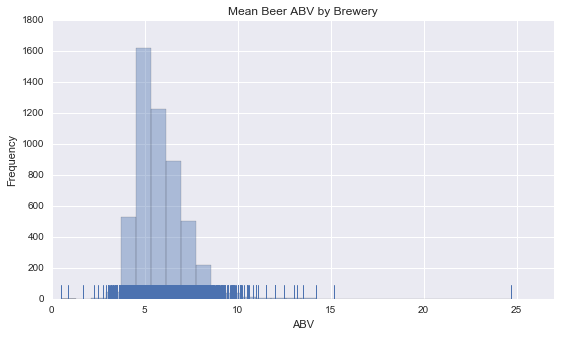

In [10]:
# Seaborn plotting
plt.figure(figsize=(9, 5))
x = meanABV_df['mean_ABV'].dropna()
figdist = sns.distplot(x, bins=30, kde=False, rug=True);

# Matplotlib graph formatting
plt.title('Mean Beer ABV by Brewery')
plt.axis([0, 27, 0, 1800])
plt.xlabel('ABV')
plt.ylabel('Frequency')
plt.show()

Visulising the data shows that most breweries brew around 5% ABV, much less than the 25% of Schorschbräu.
The rug plot shows the anomalous value of the Schorschbräu ABV.

---
### 2. If you had to pick 3 beers to recommend using only this data, which would you pick?

Looking at the dataset, the 'review_overall' input must be the most accurate metric to rank the beers. While there are other features that judge facets of the beers' quality, the user takes these all into consideration when choosing the overall score. 

For a more robust recommendation, beers with too few reveiws will be excluded. The review count is first added to the data frame, and visualised to find a good threshold. 



In [11]:
bf = df[['brewery_name','beer_name','beer_beerid','beer_abv', 'beer_style', 'review_overall']]

pd.options.mode.chained_assignment = None  # default='warn'
bf['review_count'] = bf.groupby(['beer_beerid'])['review_overall'].transform('count')
bf.describe()

,beer_beerid,beer_abv,review_overall,review_count
count,1586614.000000,1518829.000000,1586614.000000,1586614.000000
mean,21712.794279,7.042387,3.815581,535.713711
std,21818.335997,2.322526,0.720622,636.457332
min,3.000000,0.010000,0.000000,1.000000
25%,1717.000000,5.200000,3.500000,72.000000
50%,13906.000000,6.500000,4.000000,294.000000
75%,39441.000000,8.500000,4.500000,747.000000
max,77317.000000,57.700000,5.000000,3290.000000


Above, we can see that the average number of reveiws per beer is 536. 

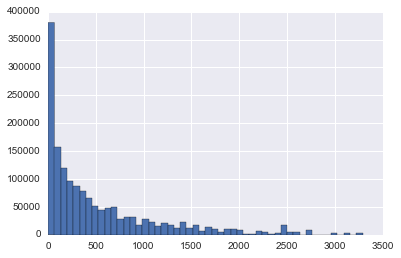

In [12]:
# Histogram to visualise review count distribution
bf.review_count.hist(bins=50)
plt.show()

With this knowledge, 100 reviews seems like a sensible threshold for the miniumum count. 

In [13]:
# Minium reviews
x = 100

# Adding overall_review mean column to data frame
bf['review_mean'] = bf.groupby(['beer_beerid'])['review_overall'].transform('mean')
bf.head(8)

# Creating summary data frame that excludes beers with < x reviews, and sorts the data
summary = bf[bf.review_count >= x].groupby('beer_beerid').head(1).sort_values('review_mean', ascending=False)
summary = summary.drop('review_overall', axis=1)
summary.head(4)

,brewery_name,beer_name,beer_beerid,beer_abv,beer_style,review_count,review_mean
334855,Kern River Brewing Company,Citra DIPA,56082,8.00,American Double / Imperial IPA,252,4.630952
482051,Brasserie Cantillon,Cantillon Blåbær Lambik,36316,5.00,Lambic - Fruit,156,4.628205
378243,The Alchemist,Heady Topper,16814,8.00,American Double / Imperial IPA,469,4.625800
1141056,Russian River Brewing Company,Deviation - Bottleworks 9th Anniversary,41928,6.83,American Wild Ale,112,4.620536


To answer the project question, the summary data frame is called.

In [14]:
# Top 3 beers with >100 reviews
summary.iloc[0:3,:]

,brewery_name,beer_name,beer_beerid,beer_abv,beer_style,review_count,review_mean
334855,Kern River Brewing Company,Citra DIPA,56082,8,American Double / Imperial IPA,252,4.630952
482051,Brasserie Cantillon,Cantillon Blåbær Lambik,36316,5,Lambic - Fruit,156,4.628205
378243,The Alchemist,Heady Topper,16814,8,American Double / Imperial IPA,469,4.625800


Graphing shows the relationship between reveiw count and overall score. Interestingly, all of the most popular beers have an overall review well above the mean (3.79).

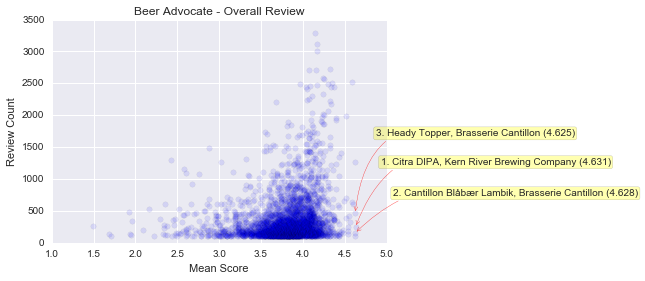

In [15]:
x = summary.review_mean
y = summary.review_count

# Create subplots and annotations
fig, ax = plt.subplots()
fig = plt.scatter(x, y, s=30, alpha=0.1)
plt.title('Beer Advocate - Overall Review')
plt.xlabel('Mean Score')
plt.ylabel('Review Count')
plt.axis([1, 5, 0, 3500])
ax.annotate('1. Citra DIPA, Kern River Brewing Company (4.631)', xy=(x[334855], y[334855]), xytext=(140,60), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=0.5', 
                            color='red'))
ax.annotate('2. Cantillon Blåbær Lambik, Brasserie Cantillon (4.628)', xy=(x[482051], y[482051]), xytext=(160,35), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=0.3', 
                            color='red'))
ax.annotate('3. Heady Topper, Brasserie Cantillon (4.625)', xy=(x[378243], y[378243]), xytext=(120,75), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=0.6', 
                            color='red'))
plt.show()

The top right data point with ~2500 reviews looks interesting too, so I'll extract that and it add it to the recommendations. 
Being the most popular high-quality beer, it might actually be available for you to source locally!

In [16]:
summary[summary.review_mean > 4.5].sort_values('review_count', ascending=False).head(4)

,brewery_name,beer_name,beer_beerid,beer_abv,beer_style,review_count,review_mean
1127975,Russian River Brewing Company,Pliny The Elder,7971,8.0,American Double / Imperial IPA,2527,4.590028
669204,Bayerische Staatsbrauerei Weihenstephan,Weihenstephaner Hefeweissbier,731,5.4,Hefeweizen,1981,4.515901
1479675,Brouwerij Westvleteren (Sint-Sixtusabdij van W...,Trappist Westvleteren 12,1545,10.2,Quadrupel (Quad),1272,4.617925
1487813,Brouwerij Westvleteren (Sint-Sixtusabdij van W...,Trappist Westvleteren 8,857,8.0,Dubbel,707,4.514144


The recommended beers, based on overall review and popularity

* **Citra DIPA** (American Double / Imperial IPA), by the *Kern River Brewing Company*
* **Cantillon Blåbær Lambik** (American Double / Imperial IPA), by *Brasserie Cantillon*
* **Heady Topper** (Lambic - Fruit), by *The Alchemist*
* **Pliny The Elder** (Imperial IPA), by the *Russian River Brewing Company* 


---
### 3. Which of the factors (aroma, taste, appearance, palette) are most important in determining the overall quality of a beer?

In [17]:
funcs = {'beer_beerid':'count',
         'review_overall':'mean',
         'review_aroma':'mean',
         'review_taste':'mean',
         'review_appearance':'mean',
         'review_palate':'mean',
         'beer_abv':'mean'}
df1 = df.groupby('beer_beerid').agg(funcs)
df1.head()

,beer_beerid,review_aroma,review_overall,beer_abv,review_palate,review_taste,review_appearance
beer_beerid,,,,,,,
3,3,4.000000,4.166667,NaN,4.166667,4.166667,3.833333
4,10,3.800000,3.700000,NaN,3.700000,3.450000,3.950000
5,424,3.205189,3.549528,4.5,3.318396,3.340802,3.485849
6,877,3.515964,3.706956,5.6,3.513113,3.645382,3.836374
7,659,3.179059,3.266313,4.2,3.106980,3.101669,3.251138


The correlation between columns needs to be investigated. Below, the Pearson product-moment correlation is calculated and plotted on a heatmap.

In [18]:
 df1.iloc[:,0:5].corr()

,beer_beerid,review_aroma,review_overall,beer_abv,review_palate
beer_beerid,1.000000,0.067120,0.055473,0.091053,0.062961
review_aroma,0.067120,1.000000,0.741132,0.340009,0.722609
review_overall,0.055473,0.741132,1.000000,0.192175,0.803974
beer_abv,0.091053,0.340009,0.192175,1.000000,0.294547
review_palate,0.062961,0.722609,0.803974,0.294547,1.000000


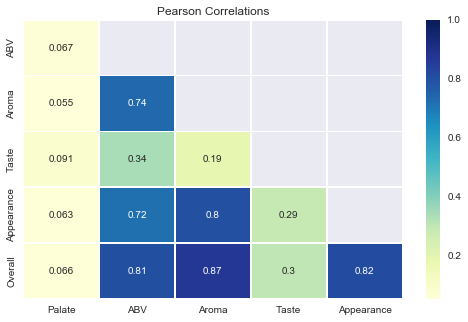

In [19]:
# Removing 'beer_beerid' and finding correlation
df2 = df1.iloc[:,0:6]
df2.columns = ['Palate', 'ABV', 'Aroma', 'Taste', 'Appearance', 'Overall']
cor_vals = df2.corr()
cor_vals = cor_vals.iloc[1:6,0:5]

# Generate a mask for the upper triangle
mask = np.zeros_like(cor_vals, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot in seaborn
plt.figure(figsize=(8.5, 5))
sns.heatmap(cor_vals, mask=mask, annot=True, linewidths=.5, cmap="YlGnBu")

plt.title("Pearson Correlations")
plt.show()

Here we can see that the most influential factors in overall score is Taste (0.87), followed by Armoa (0.81).

### 4. If you typically enjoy a beer due to its aroma and appearance, which beer style should you try?

To answer this, we need to group the dataframe by beer style, then sort by an aggregated mean of the aroma and appearance score. A scatter plot would be a good way to visualise the relationship between aroma and appearance. 

In [20]:
# Create dataframe with relevant features
bf = df[['brewery_name',
         'review_overall',
         'review_aroma',
         'review_appearance',
         'beer_style']]

# Grouping by beer_style, and aggregating statistical values
df4 = bf.groupby('beer_style').agg({'review_aroma': [np.size, np.mean, np.std], 
                                    'review_appearance': [np.size, np.mean, np.std]})

df4.head(3)

review_aroma                     review_appearance  \
                                 size      mean       std              size   
beer_style                                                                    
Altbier                          7741  3.624015  0.582302              7741   
American Adjunct Lager          30749  2.480211  0.719682             30749   
American Amber / Red Ale        45751  3.627254  0.622302             45751   

                                              
                              mean       std  
beer_style                                    
Altbier                   3.809327  0.514903  
American Adjunct Lager    2.788546  0.737899  
American Amber / Red Ale  3.810190  0.543047

Creating an aggregate mean of appearance and aroma, and then sorting by this value, gives the highest rated beer type for the two variables. 

In [21]:
# New agg_mean column and sort descending
df4['agg_mean'] = 0.5 * (df4['review_appearance', 'mean'] + df4['review_aroma', 'mean'])
df4.sort_values(('agg_mean'), ascending=False)[:5]

review_aroma                      \
                                         size      mean       std   
beer_style                                                          
American Double / Imperial Stout        50705  4.160665  0.570496   
Russian Imperial Stout                  54129  4.076576  0.542319   
Quadrupel (Quad)                        18086  4.132533  0.544143   
American Double / Imperial IPA          85977  4.097782  0.568236   
Gueuze                                   6009  4.117574  0.560086   

                                 review_appearance                      \
                                              size      mean       std   
beer_style                                                               
American Double / Imperial Stout             50705  4.163633  0.515715   
Russian Imperial Stout                       54129  4.210072  0.508614   
Quadrupel (Quad)                             18086  4.117964  0.514112   
American Double / Imperial IPA               85977  4.078916  0.469188   
Gueuze                                        6009  4.034864  0.499991   

                                  agg_mean  
                                            
beer_style                                  
American Double / Imperial Stout  4.162149  
Russian Imperial Stout            4.143324  
Quadrupel (Quad)                  4.125249  
American Double / Imperial IPA    4.088349  
Gueuze                            4.076219

To answer the question (4):

- The American Double / Imperial Stout is the recommended beer type, if you like aroma and appearance.

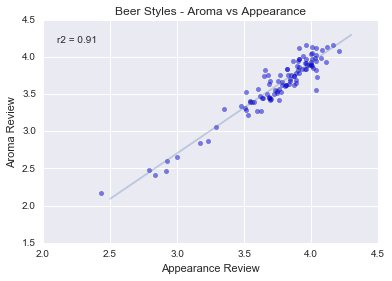

In [22]:
# Scatter plot with linear regression model
x = df4['review_appearance', 'mean'].values.reshape(-1, 1)
y = df4['review_aroma', 'mean'].values
model = LinearRegression()
model.fit(x, y)

# Plotting the data
plt.scatter(x, y, alpha=0.5)
plt.title('Beer Styles - Aroma vs Appearance')
plt.xlabel('Appearance Review')
plt.ylabel('Aroma Review')
plt.text(2.1, 4.2, 'r2 = {0:.2f}'.format(model.score(x, y)))

# Plotting the regression model
X_fit = np.linspace(2.5, 4.3, 100)[:, np.newaxis]
y_fit = model.predict(X_fit)
plt.plot(X_fit.squeeze(), y_fit, alpha=0.3);
plt.show()

Here a linear relationship is shown between the appearance and aroma score. This is evidence that a beer's look and smell are deeply linked. 

Further investigation of this could be to compare the appearance and the overall score. 

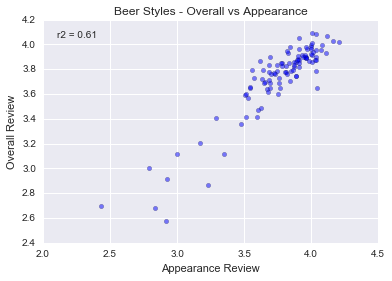

In [23]:
# Grouping by beer_style, and aggregating statistical values
df5 = bf.groupby('beer_style').agg({'review_overall': np.mean})
y = df5.review_overall.values
plt.scatter(x, y, alpha=0.5)
plt.title('Beer Styles - Overall vs Appearance')
plt.xlabel('Appearance Review')
plt.ylabel('Overall Review')
plt.text(2.1, 4.06, 'r2 = {0:.2f}'.format(model.score(x, y)))
plt.show()

Similar to the correlation score we calculated in part 3, there is a significant linear relationship between the two feature, with no obvious outliers. 

With this information we can conclude that the appearance, aroma, and overall score of a beer are strongly correlated. Beer recommendations using only the overall score is a safe and sensible option. 


Below is the CSS that edits the notebook's HTML.





___

In [24]:
CSS = """
body {
    margin: 0;
    font-family: Helvetica;
}
table.dataframe {
    border-collapse: collapse;
    border: none;
}
table.dataframe tr {
    border: none;
}
table.dataframe td, table.dataframe th {
    margin: 0;
    border: 1px solid white;
    padding-left: 0.25em;
    padding-right: 0.25em;
}
table.dataframe th:not(:empty) {
    background-color: #fec;
    text-align: left;
    font-weight: normal;
}
table.dataframe tr:nth-child(2) th:empty {
    border-left: none;
    border-right: 1px dashed #888;
}
table.dataframe td {
    border: 2px solid #ccf;
    background-color: #f4f4ff;
}
"""
from IPython.core.display import HTML
HTML('<style>{}</style>'.format(CSS))